# Feature Engineering

## 1. Importación de Librerías

In [4]:
# Utilidades generales
from datetime import datetime, timedelta
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# Manejo y procesamiento de datos
import pandas as pd
from tabulate import tabulate

# Calendario de mercados
import pandas_market_calendars as mcal

In [5]:
#IMPORTACIÓN DE LIBRERÍAS 

# -------------------------
# Utilidades generales
# -------------------------
from datetime import datetime, timedelta
import os
import glob
import warnings
warnings.filterwarnings('ignore')

# -------------------------
# Manejo y procesamiento de datos
# -------------------------
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# -------------------------
# Visualización
# -------------------------
import matplotlib.pyplot as plt

# -------------------------
# Calendario de mercados
# -------------------------
import pandas_market_calendars as mcal

# -------------------------
# Estadística y series temporales
# -------------------------
##from statsmodels.tsa.stattools import adfuller
##from statsmodels.graphics.tsaplots import plot_predict
##from statsmodels.tsa.statespace.sarimax import SARIMAX
##from statsmodels.tsa.arima.model import ARIMA as sm_ARIMA
##from statsmodels.tsa.seasonal import seasonal_decompose
##from pmdarima.arima import ARIMA as pm_ARIMA
##import pmdarima as pm
##from arch import arch_model

# -------------------------
# Modelado con LSTM
# -------------------------
##from keras.models import Sequential
##from keras.layers import LSTM, Dense, Dropout
##from keras.preprocessing.sequence import TimeseriesGenerator

# -------------------------
# Paralelización
# -------------------------
##from joblib import parallel_backend


## 2. Carga del dataset mnq_intraday_data

In [20]:
def cargar_df():
    #path = '0_preprocesamiento_datos/mnq_intraday_data.parquet' 
    archivo = './mnq_intraday_data.parquet'

    if os.path.exists(archivo):
        print("Archivo encontrado. Cargando dataset desde disco...")
        mnq_intraday = pd.read_parquet(archivo)
        
    return mnq_intraday

In [21]:
mnq_intraday = cargar_df()

Archivo encontrado. Cargando dataset desde disco...


In [22]:
# Asegurar que el índice esté en formato datetime (por si acaso)
mnq_intraday.index = pd.to_datetime(mnq_intraday.index)

# Crear una columna 'date' a partir del índice
mnq_intraday['date'] = mnq_intraday.index.date

## 3. Búsqueda de ALPHA FACTOR    

Un alpha factor es como una hipótesis cuantitativa: propone que una cierta transformación de los datos (por ejemplo, un RSI bajo o un volumen inusualmente alto) podría anticipar un movimiento futuro del precio.

Entonces, antes de entrenar un modelo LSTM, XGBoost o cualquier otro, el alpha factor te ayuda a descubrir cuáles features tienen “potencial predictivo”

**¿Qué hace realmente?**

- Evalúa si una variable (feature) tiene relación estadística con el retorno futuro.
- Te filtra las señales útiles del ruido.
- Acelera la selección de features sin tener que probar todo con modelos complejos primero.

Por ejemplo:

- Calculás el momentum 10 y ves que cuando es alto, el retorno a 5 minutos tiende a ser positivo → ese factor tiene alpha.
- Calculás el RSI 14 y no ves ninguna relación → ese factor no tiene alpha (en ese timeframe).

El Information Coefficient (IC) mide la correlación entre el alpha factor y el retorno futuro:

IC > 0: el factor predice correctamente la dirección del retorno.

IC ≈ 0: el factor no tiene poder predictivo.

IC < 0: el factor tiene un poder inverso (indica lo contrario al retorno real).

### 3.2. Hipótesis 2: Reversión a la Media (Mean Reversion)

**"Si el precio se aleja demasiado de su media móvil de corto plazo, tenderá a volver a ella."**

Justificación técnica: Alta frecuencia tiende a mostrar sobre-reacciones temporales. Este es un principio clásico del análisis técnico. En escalas de tiempo cortas, los precios tienden a oscilar alrededor de su media. Alejamientos extremos suelen generar correcciones rápidas, especialmente en activos líquidos como el MNQ.

Alpha Factor sugerido:

![image.png](attachment:image.png)

Donde:

SMA_N(t) es la media móvil simple de los últimos N minutos,

σ_N(t) es la desviación estándar en la misma ventana.


**El z-score te dice cuán lejos está un valor respecto a su promedio, medido en unidades de desviación estándar.**
Es una forma de medir si algo está “muy arriba” o “muy abajo” de lo normal.

1. Construcción del alpha factor

Usamos el z-score del precio respecto a su media móvil intradía. Cuanto más extremo el z-score, más probable la reversión.

In [23]:
mnq_intraday

,open,high,low,close,volume,date
datetime,,,,,,
2019-12-23 08:30:00-05:00,8736.25,8737.50,8736.25,8737.00,30,2019-12-23
2019-12-23 08:31:00-05:00,8737.00,8737.25,8736.00,8736.50,45,2019-12-23
2019-12-23 08:32:00-05:00,8736.50,8736.75,8735.50,8736.00,73,2019-12-23
2019-12-23 08:33:00-05:00,8736.50,8736.75,8736.00,8736.75,51,2019-12-23
2019-12-23 08:34:00-05:00,8736.75,8739.00,8736.75,8737.75,91,2019-12-23
...,...,...,...,...,...,...
2024-12-27 15:56:00-05:00,21677.25,21681.75,21663.25,21678.75,5045,2024-12-27
2024-12-27 15:57:00-05:00,21679.50,21684.25,21669.00,21682.25,2826,2024-12-27
2024-12-27 15:58:00-05:00,21682.25,21694.00,21679.25,21691.25,2770,2024-12-27


In [24]:
for N in [5, 15, 30]:
    sma_col = f'sma_{N}'
    std_col = f'std_{N}'
    z_col = f'zscore_{N}'

    mnq_intraday[sma_col] = mnq_intraday.groupby('date')['close'].transform(lambda x: x.rolling(window=N).mean())
    mnq_intraday[std_col] = mnq_intraday.groupby('date')['close'].transform(lambda x: x.rolling(window=N).std())
    mnq_intraday[z_col] = (mnq_intraday['close'] - mnq_intraday[sma_col]) / mnq_intraday[std_col]

In [25]:
mnq_intraday

,open,high,low,close,volume,date,sma_5,std_5,zscore_5,sma_15,std_15,zscore_15,sma_30,std_30,zscore_30
datetime,,,,,,,,,,,,,,,
2019-12-23 08:30:00-05:00,8736.25,8737.50,8736.25,8737.00,30,2019-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-23 08:31:00-05:00,8737.00,8737.25,8736.00,8736.50,45,2019-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-23 08:32:00-05:00,8736.50,8736.75,8735.50,8736.00,73,2019-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-23 08:33:00-05:00,8736.50,8736.75,8736.00,8736.75,51,2019-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-12-23 08:34:00-05:00,8736.75,8739.00,8736.75,8737.75,91,2019-12-23,8736.80,0.647109,1.468068,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-27 15:56:00-05:00,21677.25,21681.75,21663.25,21678.75,5045,2024-12-27,21692.45,14.198812,-0.964869,21651.266667,34.849481,0.788630,21645.541667,25.299591,1.312604
2024-12-27 15:57:00-05:00,21679.50,21684.25,21669.00,21682.25,2826,2024-12-27,21688.30,13.351498,-0.453133,21654.683333,35.230804,0.782459,21646.841667,26.164968,1.353273
2024-12-27 15:58:00-05:00,21682.25,21694.00,21679.25,21691.25,2770,2024-12-27,21687.20,12.691533,0.319110,21658.733333,35.740317,0.909804,21648.483333,27.368095,1.562647


2. Definición del target

Como en la hipótesis anterior, podés usar el retorno futuro como variable objetivo:

In [11]:
mnq_intraday['target_return_5'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x.shift(-5)) - np.log(x))
mnq_intraday['target_return_15'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x.shift(-15)) - np.log(x))
mnq_intraday['target_return_30'] = mnq_intraday.groupby('date')['close'].transform(lambda x: np.log(x.shift(-30)) - np.log(x))

3. Evaluación del alpha factor

Correlación negativa (IC < 0) validaría la hipótesis de reversión.

In [12]:
ic_z_5 = mnq_intraday.dropna().groupby('date').apply(lambda x: x['zscore_5'].corr(x['target_return_5']))
ic_z_15 = mnq_intraday.dropna().groupby('date').apply(lambda x: x['zscore_15'].corr(x['target_return_15']))
ic_z_30 = mnq_intraday.dropna().groupby('date').apply(lambda x: x['zscore_30'].corr(x['target_return_30']))

# Promedio del IC para cada ventana
print(f"Mean IC (Z-score 5 min):  {ic_z_5.mean():.4f}")
print(f"Mean IC (Z-score 15 min): {ic_z_15.mean():.4f}")
print(f"Mean IC (Z-score 30 min): {ic_z_30.mean():.4f}")


Mean IC (Z-score 5 min):  -0.0230
Mean IC (Z-score 15 min): -0.0490
Mean IC (Z-score 30 min): -0.0831


Si el IC promedio es negativo, valida la hipótesis: z-scores altos → retornos futuros negativos, y viceversa.

Como el z-score es un indicador de "desviación extrema", su efecto debería ser más marcado cuando su valor absoluto es grande.

In [16]:
ic_z_30

date
2019-12-23    0.065184
2019-12-26    0.001749
2019-12-27    0.235322
2019-12-30    0.180983
2019-12-31   -0.341337
                ...   
2024-12-18    0.299059
2024-12-19   -0.183031
2024-12-23   -0.038660
2024-12-26   -0.297999
2024-12-27    0.264325
Length: 1201, dtype: float64

## Quiero observar el comportamiento del alpha factor por minutos del día

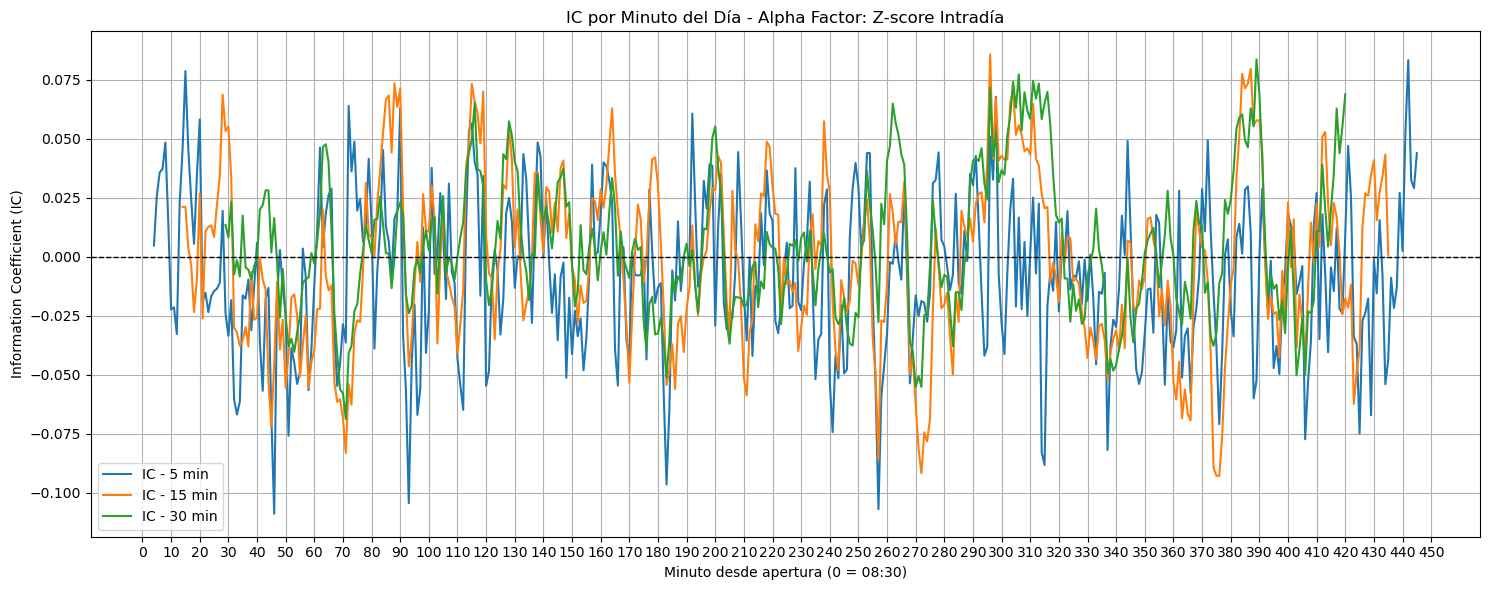

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Asegurarse de tener un identificador de fila por jornada (0 a 450)
mnq_intraday['minute_index'] = mnq_intraday.groupby('date').cumcount()

# Función para calcular IC por minuto
def compute_ic_by_minute(factor_col, target_col):
    grouped = mnq_intraday[[factor_col, target_col, 'minute_index']].dropna()
    ic_by_minute = grouped.groupby('minute_index').apply(
        lambda x: x[factor_col].corr(x[target_col])
    )
    return ic_by_minute

# Calcular IC por minuto para cada ventana temporal
ic_minute_5 = compute_ic_by_minute('zscore_5', 'target_return_5')
ic_minute_15 = compute_ic_by_minute('zscore_15', 'target_return_15')
ic_minute_30 = compute_ic_by_minute('zscore_30', 'target_return_30')


# Visualización
plt.figure(figsize=(15, 6))
plt.xticks(np.arange(0, 451, 10))
plt.plot(ic_minute_5.index, ic_minute_5, label='IC - 5 min')
plt.plot(ic_minute_15.index, ic_minute_15, label='IC - 15 min')
plt.plot(ic_minute_30.index, ic_minute_30, label='IC - 30 min')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title('IC por Minuto del Día - Alpha Factor: Z-score Intradía')
plt.xlabel('Minuto desde apertura (0 = 08:30)')
plt.ylabel('Information Coefficient (IC)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
import pandas as pd

# Asegurate de tener calculados:
# ic_minute_5, ic_minute_15, ic_minute_30
# Cada uno debe ser una pd.Series con índice = minuto del día (0 a 450)

# Consolidar en un único DataFrame
ic_minute_df = pd.DataFrame({
    'IC_zscore_5': ic_minute_5,
    'IC_zscore_15': ic_minute_15,
    'IC_zscore_30': ic_minute_30
})

# Diccionario para guardar resultados
best_zscore_analysis = {}

# Para cada columna (factor), calcular métricas
for col in ic_minute_df.columns:
    series = ic_minute_df[col].dropna()
    min_ic = series.min()                          # IC más bajo
    min_minute = series.idxmin()                   # Minuto donde ocurre
    mean_worst_30 = series.nsmallest(30).mean()    # Promedio de los 30 peores ICs

    best_zscore_analysis[col] = {
        'IC mínimo': min_ic,
        'Minuto del IC mínimo': min_minute,
        'Promedio de los 30 peores ICs': mean_worst_30
    }

# Convertir a DataFrame para visualizarlo
best_zscore_df = pd.DataFrame(best_zscore_analysis).T
print(best_zscore_df)

              IC mínimo  Minuto del IC mínimo  Promedio de los 30 peores ICs
IC_zscore_5   -0.108979                  46.0                      -0.071159
IC_zscore_15  -0.092939                 376.0                      -0.069216
IC_zscore_30  -0.068905                  71.0                      -0.044449


## 🧠 Evaluación de los Alpha Factors de Reversión a la Media

### 1. **IC mínimo**
- 🔽 Más negativo = mayor poder predictivo en su peor punto.
- ✅ **Gana `zscore_5`** con `-0.1090`.

### 2. **Promedio de los 30 peores ICs**
- 🔽 Más negativo = factor más consistentemente útil en revertir.
- ✅ **Gana `zscore_5`** con `-0.0712`.

### 3. **Minuto del IC mínimo**
- `zscore_5`: minuto 46 → 09:16 a.m.
- `zscore_15`: minuto 376 → 14:46 p.m.
- `zscore_30`: minuto 71 → 09:41 a.m.

> Todos los factores muestran cierto poder predictivo, pero el hecho de que `zscore_5` tenga su mejor desempeño **temprano en el día** lo hace especialmente interesante para estrategias intradía.

---

## ✅ Conclusión

> 🔄 **El nuevo mejor alpha factor para la hipótesis de reversión a la media es `zscore_5`**.

Porque:
- Tiene el **IC más negativo** (mayor valor predictivo en su peor minuto).
- Presenta el **promedio más bajo en sus 30 peores minutos** (más robusto).
- Opera en una **ventana horaria favorable** cerca del inicio de la jornada bursátil.

### AGREGAR ALPHA FACTOR A DATASET 

Es un indicador de reversión intradía.

Tiene más poder predictivo (negativo) en los primeros 90 minutos del día.

Ya está normalizado por día, por lo tanto es comparable entre jornadas.

In [19]:
import pandas as pd
import numpy as np

def add_mean_reversion_factor(df: pd.DataFrame, window: int = 5, price_col: str = 'close') -> pd.DataFrame:
    """
    Agrega al DataFrame una columna con el alpha factor de reversión a la media basado en z-score
    calculado sobre una media móvil simple de N minutos, por jornada.

    Parámetros:
    - df: DataFrame con columnas 'date' y 'close'.
    - window: Ventana de minutos para la media móvil (default=5).
    - price_col: Nombre de la columna de precios (default='close').

    Retorna:
    - El mismo DataFrame con una nueva columna: 'mean_reversion_factor'.
    """

    df = df.copy()

    # Media móvil y desviación estándar por día
    sma_col = f'sma_{window}'
    std_col = f'std_{window}'
    z_col = 'mean_reversion_factor'

    df[sma_col] = df.groupby('date')[price_col].transform(lambda x: x.rolling(window=window).mean())
    df[std_col] = df.groupby('date')[price_col].transform(lambda x: x.rolling(window=window).std())

    # Z-score como alpha factor
    df[z_col] = (df[price_col] - df[sma_col]) / df[std_col]

    return df


In [ ]:
mnq_intraday = add_mean_reversion_factor(mnq_intraday, window=5)
